In [1]:
import numpy as np
import pandas as pd
import pickle, os
import spacy
import fasttext
import re
import pickle
import string

from tqdm.auto import tqdm, trange
from scipy.spatial.distance import cosine

from utils import text_cleaning, find_top_n, pro_labeling , mat_labeling

from sklearn.feature_extraction.text import TfidfVectorizer

with open('abstract_list.pkl', 'rb') as f:
    abstracts = pickle.load(f)
with open('title_list.pkl', 'rb') as f:
    titles = pickle.load(f)

In [2]:
# Concatenating pdfs and titles for tfidf
pdf_title = abstracts.copy() 
for text in titles:
    pdf_title.append(text)

In [3]:
len(pdf_title)

20000

In [4]:
# Tfidf for abstracts
vec = TfidfVectorizer(max_df=0.9,min_df=10,stop_words='english',ngram_range=(1, 2))
vec.fit(pdf_title)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [5]:
len(vec.vocabulary_)

10908

In [6]:
# path = "crawl-300d-2M.vec"

# with open('10 k training data.txt','w',encoding="utf-8") as f:
#     for text in pdf_title:
#         f.write('\n'.join(text.split()))

# train_data = '10 k training data.txt'

# ft_model = fasttext.train_unsupervised(input=train_data, pretrainedVectors=path, dim=300)

In [7]:
# Saving the model
#ft_model.save_model("ft_model_arxiv.bin")

# Loading the model
ft_model = fasttext.load_model("ft_model_arxiv.bin")

In [8]:
# Creating sentences for each document with the strongest tfidf words

tfidf_words_abstract = []

for abstract in tqdm(abstracts):
    tfidf_words_abstract.append(" ".join(find_top_n(abstract,vec,10)))
    
tfidf_words_title = []

for title in tqdm(titles):
    tfidf_words_title.append(" ".join(find_top_n(title,vec,10)))

In [9]:
len(abstracts)

10000

In [10]:
len(titles)

10000

In [11]:
######################

In [12]:
tfidf_words_abstract[:5]

['fullerene shell iteration multi shell multi factor reduce symmetry symmetry base low unoccupied',
 'recursion path integral molecular orbital integral path local density density state method orbital state',
 'transmission superlattice analytical result numerical numerical simulation phonon localization analytical fluctuation random',
 'superlattice transmission order partially layer fluctuation deterministic version teller analytically',
 'evaporation growth particle model surface model growth kinetic rate equation different growth analysis dimensional structure']

In [13]:
tfidf_words_title[:5]

['structure single fullerene multiple shell electronic structure carbon single electronic structure finding suggest',
 'recursion path integral analytic study electronic integral path electronic property approach electronic property',
 'semiconductor superlattice function approach green function localization green superlattice fluctuation random transmission rate',
 'semiconductor superlattice universal localization superlattice fluctuation transmission degree control phonon semiconductor',
 'submonolayer monomer evaporation simple model simple growth model effect film present film structure']

In [14]:
# list(filter(lambda x:len(x.split())==2,list(np.array(vec.get_feature_names()))))

### Finding the cosine similarities between documents and labels

* **Labels** : How materials are produced
* **Material** : The material type after producuction


* **SLM** : Selective laser melting
* **DMLS** : Direct metal laser sintering
* **FDM** : Fused deposition modeling 
* **FFF** : Fused filament fabrication
* **EAM** : Extrusion-based additive manufacturing


* Metal
* Polymer 
* Ceramic  

In [15]:
pro_1 = ft_model.get_sentence_vector('selective laser melting')
pro_2 = ft_model.get_sentence_vector('direct metal laser sintering')

pro_3 = ft_model.get_sentence_vector('fused deposition modeling')
pro_4 = ft_model.get_sentence_vector('fused filament fabrication')
pro_5 = ft_model.get_sentence_vector('extrusion based additive manufacturing')

metal = ft_model.get_word_vector('metal')
ceramic = ft_model.get_word_vector('ceramic')
polymer = ft_model.get_word_vector('polymer')

# feature_1 = get_embedding('fracture toughness')
# feature_2 = get_embedding('tensile strength')
# feature_3 = get_embedding('yield strength')
# feature_4 = get_embedding('elastic modulus')
# feature_5 = get_embedding('strain fracture break')
# feature_6 = get_embedding('weibull modulus')

In [16]:
def create_df_abs():
    
    d_abs = {'Titles':titles,
         'Abstracts':abstracts,
         'Abs_Production':abs_production,
         'Abs_Production_score':abs_production_cos_score,
         'Abs_Material':abs_material,
         'Abs_Material_score':abs_material_cos_score
        }
    
    df = pd.DataFrame(d_abs)
    #df["Production/Material"] = df["Abs_Production"] + " / " + df["Abs_Material"]
    
    return df

In [17]:
def create_df_title():
    
    d_title = {'Titles':titles,
         'Abstracts':abstracts,
         'Title_Production':title_production,
         'Title_Production_score':title_production_cos_score,
         'Title_Material':title_material,
         'Title_Material_score':title_material_cos_score
        }
    
    df = pd.DataFrame(d_title)
    #df["Production/Material"] = df["Title_Production"] + " / " + df["Title_Material"]
    
    return df

In [18]:
abs_production , abs_production_cos_score = pro_labeling(tfidf_words_abstract,ft_model,cosine,pro_1,pro_2,pro_3,pro_4,pro_5)
abs_material , abs_material_cos_score = mat_labeling(tfidf_words_abstract,ft_model,cosine,metal,ceramic,polymer)
df_abs = create_df_abs()

title_production , title_production_cos_score = pro_labeling(tfidf_words_title,ft_model,cosine,pro_1,pro_2,pro_3,pro_4,pro_5)
title_material , title_material_cos_score = mat_labeling(tfidf_words_title,ft_model,cosine,metal,ceramic,polymer)
df_title = create_df_title()

In [19]:
df_abs["Abs_Production"].value_counts()

FDM or FFF or EAM    5816
SLM or DMLS          4184
Name: Abs_Production, dtype: int64

In [20]:
df_title["Title_Production"].value_counts()

FDM or FFF or EAM    6393
SLM or DMLS          3607
Name: Title_Production, dtype: int64

In [21]:
df_abs["Abs_Material"].value_counts()

Ceramic    4039
Polymer    3254
Metal      2707
Name: Abs_Material, dtype: int64

In [22]:
df_title["Title_Material"].value_counts()

Ceramic    4143
Polymer    3480
Metal      2377
Name: Title_Material, dtype: int64

In [23]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [24]:
def visu_pro(doc):
    
    X= []

    for text in doc:
        X.append(ft_model.get_sentence_vector(text))

    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    pca_df = pd.DataFrame(index=titles,columns=['First Component','Second Component'],data=X_reduced)
    
    if doc == tfidf_words_abstract:
        pca_df["Labels"] = df_abs["Abs_Production"].values
    else :
        pca_df["Labels"] = df_title["Title_Production"].values

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.scatterplot(x=pca_df['First Component'],y=pca_df['Second Component'],hue=pca_df['Labels'],palette ='Set1')
    
    return pca_df

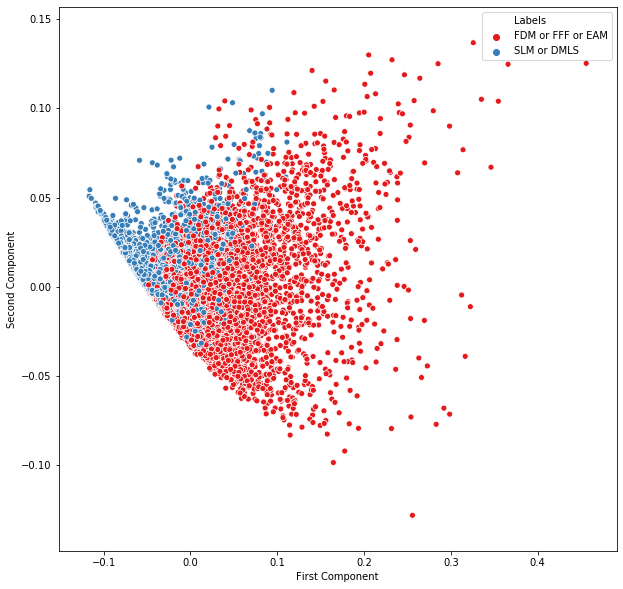

In [25]:
a_pro = visu_pro(tfidf_words_abstract)

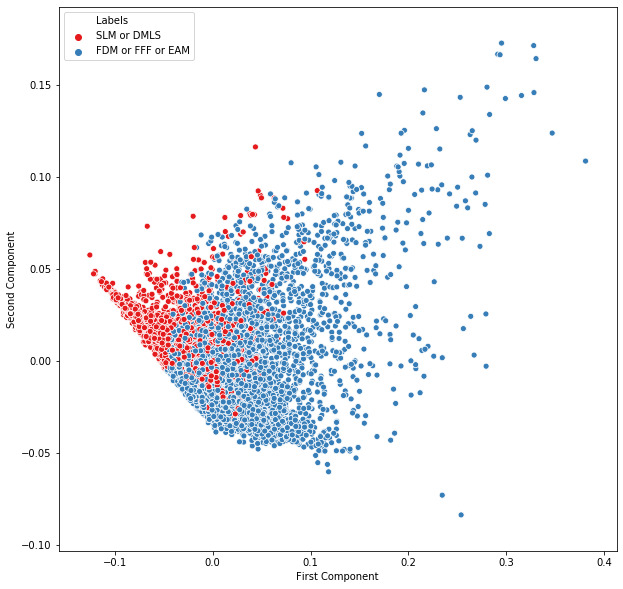

In [26]:
t_pro = visu_pro(tfidf_words_title)

In [27]:
def visu_mat(doc):
    
    X= []

    for text in doc:
        X.append(ft_model.get_sentence_vector(text))

    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    pca_df = pd.DataFrame(index=titles,columns=['First Component','Second Component'],data=X_reduced)
    
    if doc == tfidf_words_abstract:
        pca_df["Labels"] = df_abs["Abs_Material"].values
    else :
        pca_df["Labels"] = df_title["Title_Material"].values

    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.scatterplot(x=pca_df['First Component'],y=pca_df['Second Component'],hue=pca_df['Labels'],palette ='Set1')
    
    return pca_df

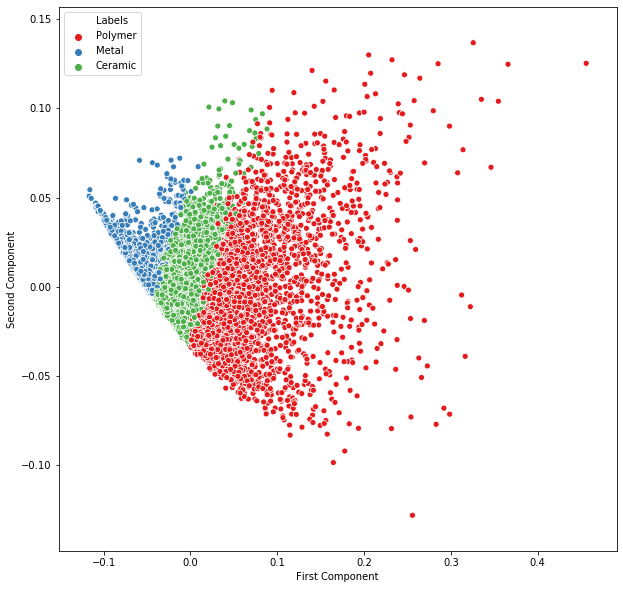

In [28]:
a_mat = visu_mat(tfidf_words_abstract)

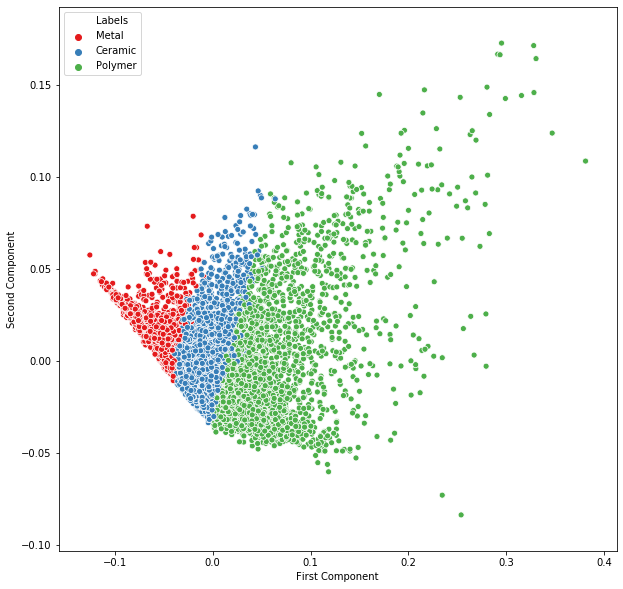

In [29]:
t_mat = visu_mat(tfidf_words_title)

In [30]:
# import re

# len(re.findall('ceramic',max_material)) # 7 ceramic in abstract with most score

### 3rd level of classification

* **Features** : Features of materials


* Fracture toughness or Work of fracture
* Tensile strength or ultimate tensile strength
* Yield strength
* Elastic modulus or Young’s modulus
* Strain at break or strain at fracture or fracture strain
* Weibull modulus

In [31]:
# df[df['M_score']== min(df['M_score'])]

In [32]:
# df["Documents/Abstracts"][df['M_score'].idxmin()] # least cos score

In [33]:
# df["Documents/Abstracts"][df['M_score'].idxmax()] # most cos score

In [34]:
#df.to_csv("data labeling.csv")